In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import joblib

df, X_hybrid = joblib.load("../data/hybrid_embeddings.pkl")

# ============================================================
# recommend similar jobs given a job index
# ============================================================
def recommend_similar_jobs(job_index, top_k=10):
    """
    Recommend top_k jobs similar to the job at job_index,
    based on cosine similarity over X_hybrid.
    """
    if job_index < 0 or job_index >= X_hybrid.shape[0]:
        raise IndexError("job_index out of range")

    # 1 x D sparse row
    query_vec = X_hybrid[job_index]

    # Compute cosine similarity with all jobs
    sims = cosine_similarity(query_vec, X_hybrid).flatten()

    # Sort by similarity (descending), skip the job itself
    ranked_idx = np.argsort(-sims)
    ranked_idx = ranked_idx[ranked_idx != job_index]

    top_idx = ranked_idx[:top_k]
    top_sims = sims[top_idx]

    # Build a nice result DataFrame
    results = df.iloc[top_idx].copy()
    results["similarity"] = top_sims

    # Reorder columns for readability
    cols = [
        "job_title",
        "company",
        "company_size_group",
        "salary_max",
        "seniority_level",
        "skills_clean",
        "similarity",
    ]
    # Some columns (like company) may not exist in this df subset, handle that:
    available_cols = [c for c in cols if c in results.columns]
    return results[available_cols]

# Example: try recommendations for job at index 0
print("\n=== Recommendations for job index 0 ===")
print(df.iloc[0][["job_title", "company_size_group", "salary_max", "skills_clean"]])
print("\nTop-10 similar jobs:")
print(recommend_similar_jobs(0, top_k=10).to_string(index=False))



=== Recommendations for job index 0 ===
job_title                                               data scientist
company_size_group                                               large
salary_max                                                    200938.0
skills_clean          spark|r|python|scala|machine learning|tensorflow
Name: 0, dtype: object

Top-10 similar jobs:
     job_title company_size_group  salary_max seniority_level                                             skills_clean  similarity
data scientist              large    200934.0          senior     spark|r|python|scala|sql|machine learning|tensorflow    0.984204
data scientist              large    197284.0          senior     spark|r|python|scala|sql|machine learning|tensorflow    0.983649
data scientist              large    183991.0          senior     spark|r|python|scala|sql|machine learning|tensorflow    0.977853
data scientist              large    164400.0          senior         spark|r|python|scala|machine learnin


=== Example recommendations for job index 0 ===
job_title                                               data scientist
company_size_group                                               large
salary_max                                                    200938.0
skills_clean          spark|r|python|scala|machine learning|tensorflow
Name: 0, dtype: object
     job_title company_size_group  salary_max  similarity
data scientist              large    200934.0    0.984204
data scientist              large    197284.0    0.983649
data scientist              large    183991.0    0.977853
data scientist              large    164400.0    0.975021
data scientist              large    213719.0    0.971664
data scientist              large    215273.0    0.971245
data scientist              large    165590.0    0.959162
data scientist              large    261214.0    0.947043
data scientist              large    263104.0    0.944944
data scientist              large    263106.0    0.944942
data s

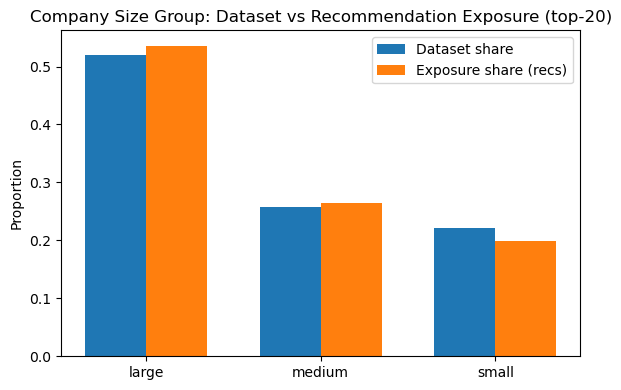

In [8]:
import matplotlib.pyplot as plt

# ============================================================
# Baseline recommender: similar jobs by index
# ============================================================
def recommend_similar_jobs(job_index, top_k=20):
    """
    Recommend top_k jobs similar to the job at job_index,
    based on cosine similarity over X_hybrid.
    """
    if job_index < 0 or job_index >= X_hybrid.shape[0]:
        raise IndexError("job_index out of range")

    query_vec = X_hybrid[job_index]
    sims = cosine_similarity(query_vec, X_hybrid).flatten()

    # Sort by similarity (descending), skip the job itself
    ranked_idx = np.argsort(-sims)
    ranked_idx = ranked_idx[ranked_idx != job_index]

    top_idx = ranked_idx[:top_k]
    top_sims = sims[top_idx]

    results = df.iloc[top_idx].copy()
    results["similarity"] = top_sims

    return results


# Quick test
print("\n=== Example recommendations for job index 0 ===")
print(df.iloc[0][["job_title", "company_size_group", "salary_max", "skills_clean"]])
print(
    recommend_similar_jobs(0, top_k=20)[
        ["job_title", "company_size_group", "salary_max", "similarity"]
    ].to_string(index=False)
)


# ============================================================
# Exposure bias measurement (k=20)
# ============================================================
def measure_exposure_bias(num_seeds=300, top_k=20, random_state=42):
    rng = np.random.default_rng(random_state)
    n = len(df)

    # Filter dataset to exclude unknowns for fair comparison
    valid_df = df[df["company_size_group"] != "unknown"].copy()

    # Compute dataset-level group proportions (small/medium/large only)
    dataset_counts = valid_df["company_size_group"].value_counts().sort_index()
    dataset_share = dataset_counts / dataset_counts.sum()

    seed_indices = rng.integers(0, n, size=num_seeds)

    exposure_counts = {}

    for idx in seed_indices:
        recs = recommend_similar_jobs(idx, top_k=top_k)

        # Drop unknown company group from the recommended list
        recs_valid = recs[recs["company_size_group"] != "unknown"]

        counts = recs_valid["company_size_group"].value_counts()
        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    # Convert to Series
    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    # Build summary table
    groups = sorted(dataset_share.index)

    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print(f"\n=== Exposure Bias Summary (num_seeds={num_seeds}, top_k={top_k}) ===")
    print(summary.to_string(index=False))

    # Plot dataset vs exposure
    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title("Company Size Group: Dataset vs Recommendation Exposure (top-20)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return summary


# ============================================================
# 13. Run bias measurement
# ============================================================
bias_summary = measure_exposure_bias(num_seeds=300, top_k=20)



=== Index-Based Exposure Bias Summary ===
company_size_group  dataset_share  exposure_share  exposure_ratio
             small       0.221622           0.152        0.685854
            medium       0.258378           0.130        0.503138
             large       0.520000           0.718        1.380769


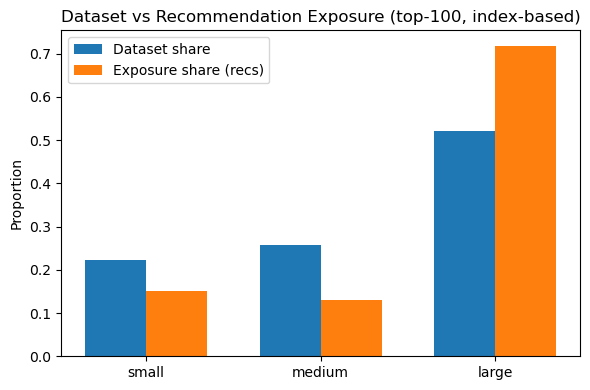

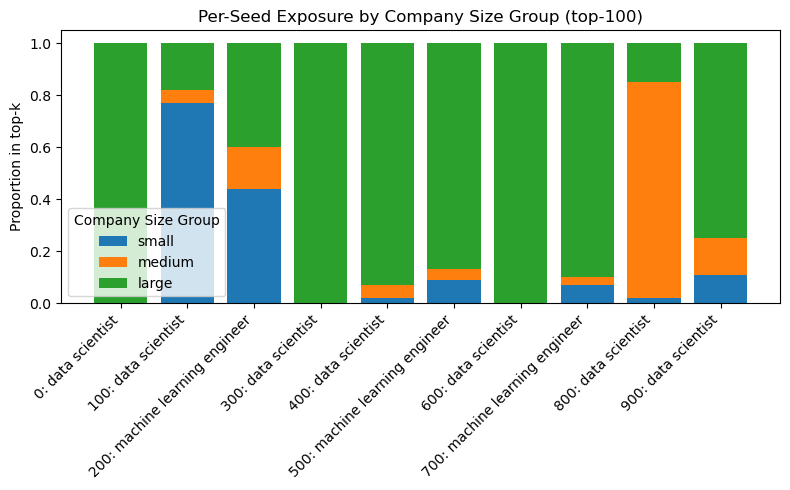

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Bias measurement based on JOB INDICES using recommend_similar_jobs()
# ============================================================

def measure_exposure_bias_job_indices(indices, top_k=20):
    """
    Measure exposure bias using index-based job recommendations.

    For each index in `indices`:
      - call recommend_similar_jobs(idx, top_k)
      - count how many small/medium/large company jobs appear
    Then:
      - compare exposure distribution to dataset distribution
      - return summary DataFrame + per-seed breakdown
    """

    # ---- 1. Dataset-level distribution (exclude 'unknown') ----
    df_valid = df[df["company_size_group"] != "unknown"].copy()

    dataset_counts = (
        df_valid["company_size_group"]
        .value_counts()
        .sort_index()
    )
    dataset_share = dataset_counts / dataset_counts.sum()

    # ---- 2. Aggregate exposure across all seeds ----
    exposure_counts = {}
    per_seed_exposure = []  # for per-seed plot

    for idx in indices:
        recs = recommend_similar_jobs(idx, top_k=top_k)

        # Ensure we drop unknowns (if any)
        recs_valid = recs[recs["company_size_group"] != "unknown"].copy()

        counts = recs_valid["company_size_group"].value_counts()
        exposure_counts_for_seed = {
            "seed_index": idx,
            "seed_title": str(df.iloc[idx]["job_title"]) if "job_title" in df.columns else f"job_{idx}",
            "small": counts.get("small", 0),
            "medium": counts.get("medium", 0),
            "large": counts.get("large", 0),
        }
        per_seed_exposure.append(exposure_counts_for_seed)

        for group, c in counts.items():
            exposure_counts[group] = exposure_counts.get(group, 0) + c

    # Convert overall exposure to shares
    exposure_series = pd.Series(exposure_counts).sort_index()
    total_recs = exposure_series.sum()
    exposure_share = exposure_series / total_recs

    # ---- 3. Build summary table (overall) ----
    groups = ["small", "medium", "large"]
    rows = []
    for g in groups:
        ds = float(dataset_share.get(g, 0.0))
        es = float(exposure_share.get(g, 0.0))
        ratio = es / ds if ds > 0 else np.nan
        rows.append({
            "company_size_group": g,
            "dataset_share": ds,
            "exposure_share": es,
            "exposure_ratio": ratio,
        })

    summary = pd.DataFrame(rows)

    print("\n=== Index-Based Exposure Bias Summary ===")
    print(summary.to_string(index=False))

    # ---- 4. Overall bar plot: dataset vs exposure ----
    x = np.arange(len(summary))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2, summary["dataset_share"], width, label="Dataset share")
    plt.bar(x + width/2, summary["exposure_share"], width, label="Exposure share (recs)")

    plt.xticks(x, summary["company_size_group"])
    plt.ylabel("Proportion")
    plt.title(f"Dataset vs Recommendation Exposure (top-{top_k}, index-based)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 5. Per-seed stacked bar plot ----
    per_seed_df = pd.DataFrame(per_seed_exposure)

    # Normalize per seed to proportions
    per_seed_df["total"] = per_seed_df[["small", "medium", "large"]].sum(axis=1)
    for g in groups:
        per_seed_df[g + "_share"] = np.where(
            per_seed_df["total"] > 0,
            per_seed_df[g] / per_seed_df["total"],
            0.0,
        )

    # Shorten seed labels for plotting: "idx: title..."
    per_seed_df["seed_label"] = (
        per_seed_df["seed_index"].astype(str)
        + ": "
        + per_seed_df["seed_title"].str.slice(0, 25)
        + np.where(per_seed_df["seed_title"].str.len() > 25, "...", "")
    )

    plt.figure(figsize=(8, 5))
    bottom = np.zeros(len(per_seed_df))
    colors = {"small": "tab:blue", "medium": "tab:orange", "large": "tab:green"}

    for g in groups:
        plt.bar(
            per_seed_df["seed_label"],
            per_seed_df[g + "_share"],
            bottom=bottom,
            label=g,
            color=colors[g],
        )
        bottom += per_seed_df[g + "_share"].values

    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Proportion in top-k")
    plt.title(f"Per-Seed Exposure by Company Size Group (top-{top_k})")
    plt.legend(title="Company Size Group")
    plt.tight_layout()
    plt.show()

    return summary, per_seed_df


# ============================================================
# Example: run bias measurement on a set of seed indices
# ============================================================

seed_indices = [
    0,
    100,
    200,
    300,
    400,
    500,
    600,
    700,
    800,
    900
]

bias_summary_index, per_seed_detail = measure_exposure_bias_job_indices(
    indices=seed_indices,
    top_k=100,
)
